In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [42]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_fixed")
# features = ["game_completed", "relative_strength", "score_difference", "type.id", "home_has_possession", "end.down", "end.yardsToEndzone", "end.distance", "field_position_shift", "home_timeouts_left", "away_timeouts_left"]
features = ["relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]
# features = ["relative_strength", "score_difference", "home_has_possession"]

/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML


In [43]:
# Reset the modules
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

import process_data
training_data = process_data.load_data(interpolated_dir, 
                                       years = [2016, 2017,2018, 2019, 2020, 2021, 2022, 2023], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

# validation_data = process_data.load_data(interpolated_dir, 
#                                        years = [2023], 
#                                        history_length = 0, 
#                                        features = features, 
#                                        label_feature = "home_win",
#                                        train = True
#                                        )

test_data = process_data.load_data(interpolated_dir, 
                                       years = [2024],
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win",
                                       train = False
                                       )


Loading data for 2022
  Processing 271 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  Completed processing 2019
Loading data for 2021
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2021
Loading data for 2020
  Processing 255 CSV files in parallel with 8 workers...
  Completed processing 2020
Loading data for 2018
  Processing 255 CSV files in parallel with 8 workers...
  Completed processing 2018
Loading data for 2016
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2016
Loading data for 2022
skipping  2022
Loading data for 2024
  Processing 272 CSV 

In [157]:
# Load edge-case datasets (filter by timestep threshold and score_difference)
# Reload module to pick up the new function
modules_to_reload = [
    'process_data',
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
import process_data
edge_featues = ["relative_strength", "score_difference", "home_has_possession", "end.down",  "end.distance", "end.yardsToEndzone", "home_timeouts_left", "away_timeouts_left"]
edge_threshold = 0.95  # minimum timestep to include (adjust as needed)
edge_training_data = process_data.load_edge_case_data(
    interpolated_dir,
    years=[2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
    history_length=0,
    features=edge_featues,
    label_feature='home_win',
    threshold=edge_threshold,
    train=True
)
edge_test_data = process_data.load_edge_case_data(
    interpolated_dir,
    years=[2024],
    history_length=0,
    features=edge_featues,
    label_feature='home_win',
    threshold=edge_threshold,
    train=False
)

print('Num train entries:', len(edge_training_data))
print('Num test entries:', len(edge_test_data))

Loading data for 2022
  Processing 271 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2022
Loading data for 2024
skipping  2024
Loading data for 2023
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2023
Loading data for .DS_Store
Loading data for 2017
  Processing 254 CSV files in parallel with 8 workers...
  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  Completed processing 2017
Loading data for 2019
  Processing 256 CSV files in parallel with 8 workers...
  Completed processing 2019
Loading data for 2021
  Processing 272 CSV files in parallel with 8 workers...
  Completed processing 2019
Loading data for

In [158]:
# Train a single LogisticRegressionModel on one timestep from the edge-case data
modules_to_reload = [
    'models.logistic_regression',
    'models.Model'
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
from models.logistic_regression import LogisticRegressionModel
from sklearn.model_selection import train_test_split

# Define numeric/other features here so this cell is self-contained
edge_numeric_features = ["score_difference", "relative_strength", "end.yardsToEndzone", "end.distance"]
edge_other_features = ["home_has_possession", "end.down", "home_timeouts_left", "away_timeouts_left"]

# Choose timestep to train on (by default the largest available)
if not edge_training_data:
    raise ValueError("edge_training_data is empty")

# Prepare training data for selected timestep
X = np.array([entry["rows"].reshape(-1) for entry in edge_training_data])
y = np.array([entry["label"] for entry in edge_training_data])

# Instantiate and train the model
single_model = LogisticRegressionModel(
    numeric_features=edge_numeric_features,
    other_features=edge_other_features,
    all_features=edge_featues,
    use_calibration=False,
    optimize_hyperparams=False
)



single_model.fit(X, y)
print("Single model trained. Summary:")
print(single_model.model)

# Keep model in notebook namespace
edge_single_model = single_model

: Training Loss = 0.4672, Accuracy = 0.7884, Test Loss = 0.4580, Test Accuracy = 0.7900
Single model trained. Summary:
LogisticRegression(max_iter=2000, random_state=42)


In [159]:
# Train a single DirectClassifier (neural network) on one timestep from the edge-case data
modules_to_reload = [
    'models.direct_prediction_network',
    'models.Model'
]
for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

from models.direct_prediction_network import DirectPredictionNetwork, DirectClassifier
import torch
from torch import nn
from sklearn.model_selection import train_test_split

# Choose timestep to train on (by default the largest available)
if not edge_training_data:
    raise ValueError("edge_training_data is empty")

# Prepare training data (flatten rows to 2D)
X = np.array([np.asarray(entry['rows']).reshape(-1) for entry in edge_training_data], dtype=np.float32)
y = np.array([entry['label'] for entry in edge_training_data], dtype=np.float32)

# Train/validation split
if len(X) < 10:
    print(f"Too few samples ({len(X)}) - using all for training")
    X_train, y_train, X_val, y_val = X, y, None, None
else:
    unique, counts = np.unique(y, return_counts=True)
    stratify = y if (len(unique) > 1 and counts.min() >= 2) else None
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42, stratify=stratify)

print(f"Prepared X_train shape: {X_train.shape}, X_val shape: {None if X_val is None else X_val.shape}")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build network
input_dim = X.shape[1]
direct_net = DirectPredictionNetwork(input_dim=input_dim, hidden_dims=[64, 32, 16, 8], dropout_rate=0.2, num_layers=4).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(direct_net.parameters(), lr=1e-3, weight_decay=1e-4)

# Instantiate classifier
direct_classifier = DirectClassifier(
    model=direct_net,
    epochs=50,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    features=edge_featues,  # uses same feature ordering as the dataset
    scheduler=None,
    use_scaler=True,
    optimize_hyperparams=False
)

# Train (classifier handles internal scaling and uses provided val set)
direct_classifier.fit(X_train, y_train, val_X=X_val, val_y=y_val, batch_size=64, verbose=True)

print("Direct classifier training finished.")
print("Train loss:", direct_classifier.final_train_loss)
print("Train accuracy:", direct_classifier.final_train_accuracy)
print("Val loss:", direct_classifier.final_val_loss)
print("Val accuracy:", direct_classifier.final_val_accuracy)

# Keep classifier in notebook namespace
edge_direct_classifier = direct_classifier

Prepared X_train shape: (16513, 8), X_val shape: (1835, 8)
Starting training on device: cpu
Direct classifier training finished.
Train loss: 0.39711766549058863
Train accuracy: 0.8224429237570399
Val loss: 0.38183743994811487
Val accuracy: 0.8332425068119891
Direct classifier training finished.
Train loss: 0.39711766549058863
Train accuracy: 0.8224429237570399
Val loss: 0.38183743994811487
Val accuracy: 0.8332425068119891


In [141]:
# other_features = [
#             "type.id",             # Play type (categorical)
#             "home_has_possession", # Binary indicator
#             "end.down",            # Down number (1-4, discrete)
#             "home_timeouts_left",  # Discrete count (0-3)
#             "away_timeouts_left",  # Discrete count (0-3)
#             "game_completed"
#         ]
# numeric_features = [
#     "score_difference",
#     "relative_strength", 
#     "end.yardsToEndzone", 
#     "end.distance", 
#     "field_position_shift"
# ]
other_features = [
            "home_has_possession", # Binary indicator
            "end.down",            # Down number (1-4, discrete)
            "home_timeouts_left",  # Discrete count (0-3)
            "away_timeouts_left",  # Discrete count (0-3)
        ]
numeric_features = [
    "score_difference",
    "relative_strength", 
    "end.yardsToEndzone", 
    "end.distance", 
]

In [78]:
# Setup model for each timestep
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
# create an array of logistic regression models

modules_to_reload = [
    'models.logistic_regression',
    'models.Model'
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
from models.Model import Model
from models.logistic_regression import setup_logistic_regression_models

models = setup_logistic_regression_models(training_data, None, numeric_features, other_features, features, optimize_hyperparams=False, use_calibration=False)


Processing timestep: 0.0
Timestep 0.00% : Training Loss = 0.6243, Accuracy = 0.6495, Test Loss = 0.6381, Test Accuracy = 0.6537
Processing timestep: 0.005
Timestep 0.50% : Training Loss = 0.6318, Accuracy = 0.6394, Test Loss = 0.6360, Test Accuracy = 0.6158
Processing timestep: 0.01
Timestep 1.00% : Training Loss = 0.6189, Accuracy = 0.6442, Test Loss = 0.6357, Test Accuracy = 0.6408
Processing timestep: 0.015
Timestep 1.50% : Training Loss = 0.6320, Accuracy = 0.6352, Test Loss = 0.6182, Test Accuracy = 0.6624
Processing timestep: 0.02
Timestep 2.00% : Training Loss = 0.6304, Accuracy = 0.6432, Test Loss = 0.6554, Test Accuracy = 0.6098
Processing timestep: 0.025
Timestep 2.50% : Training Loss = 0.6312, Accuracy = 0.6379, Test Loss = 0.6375, Test Accuracy = 0.6565
Processing timestep: 0.03
Timestep 3.00% : Training Loss = 0.6186, Accuracy = 0.6591, Test Loss = 0.6347, Test Accuracy = 0.6276
Processing timestep: 0.035
Timestep 3.50% : Training Loss = 0.6267, Accuracy = 0.6418, Test Los

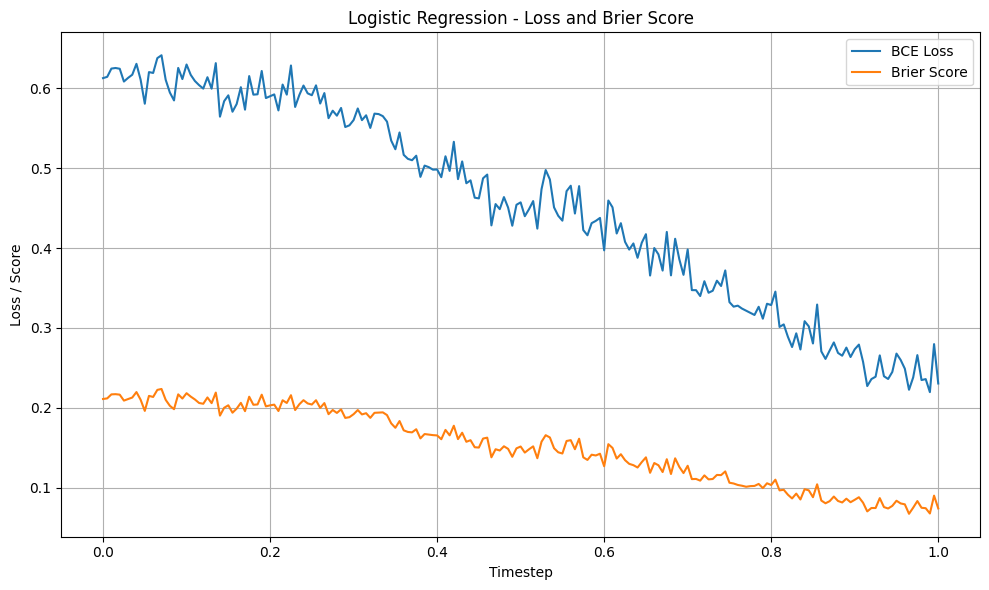

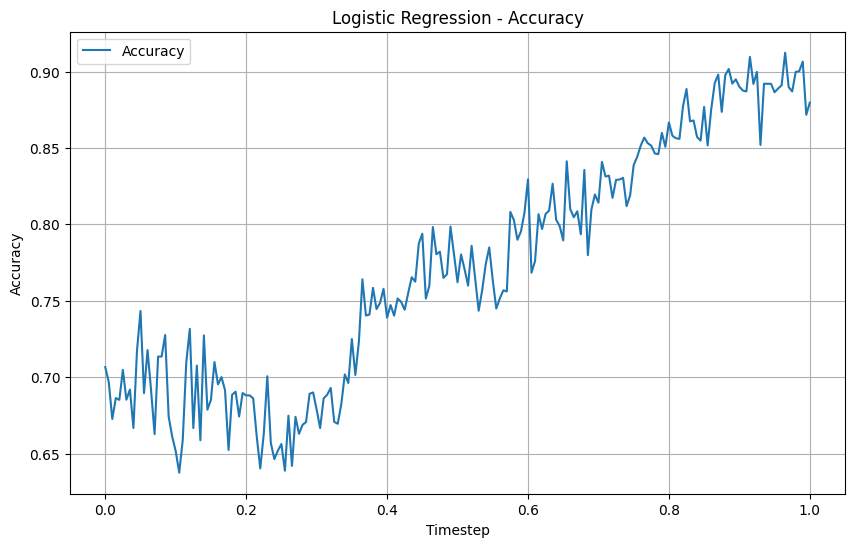

In [79]:
# # Test accuracy of model for each timestep on test data and plot
# accuracies = []
# timesteps = []
import process_data
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

x = process_data.plot_loss(models, test_data, "Logistic Regression")
process_data.plot_accuracy(models, test_data, "Logistic Regression")

In [80]:
model = models[0.99]
# features = ["relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]
data_point = [0.5, -4, 1, 1, 1, 1, 1, 1]
model.predict_proba([data_point])

array([[0.73395349, 0.26604651]])

In [156]:
# Save the model
import pickle
filename = 'logistic_regression_model.pickle'
pickle.dump(models, open(filename, 'wb'))

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
%reload_ext autoreload
from models.utils import SHAP_analysis
# model = models[0.99]
# # Health Check:
# if hasattr(model.model, "coef_"):
#     feature_names = model.all_features if hasattr(model, "all_features") else None
#     coefs = model.model.coef_[0]  # shape (n_features,)
#     if feature_names is not None and len(feature_names) == len(coefs):
#         for name, coef in zip(feature_names, coefs):
#             print(f"{name}: {coef}")

SHAP_analysis(models, training_data, test_data, "logistic_regression", "shap_values/LR", num_threads = 1)
# x = np.array([[0.1, 0.9, 20, 1, 0, 1, 50, 20, 2, 2, 2]])
# model.predict_proba(x)


Processing 201 timesteps (skipping 0 already done).
Saved logistic_regression_0.0.npz
Saved logistic_regression_0.005.npz
Saved logistic_regression_0.01.npz
Saved logistic_regression_0.015.npz
Saved logistic_regression_0.02.npz
Saved logistic_regression_0.025.npz
Saved logistic_regression_0.03.npz
Saved logistic_regression_0.035.npz
Saved logistic_regression_0.04.npz
Saved logistic_regression_0.045.npz
Saved logistic_regression_0.05.npz
Saved logistic_regression_0.055.npz
Saved logistic_regression_0.06.npz
Saved logistic_regression_0.065.npz
Saved logistic_regression_0.07.npz
Saved logistic_regression_0.075.npz
Saved logistic_regression_0.08.npz
Saved logistic_regression_0.085.npz
Saved logistic_regression_0.09.npz
Saved logistic_regression_0.095.npz
Saved logistic_regression_0.1.npz
Saved logistic_regression_0.105.npz
Saved logistic_regression_0.11.npz
Saved logistic_regression_0.115.npz
Saved logistic_regression_0.12.npz
Saved logistic_regression_0.125.npz
Saved logistic_regression_0

In [169]:
modules_to_reload = [
    "process_data"
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]
import process_data
features = ["relative_strength", "score_difference", "home_has_possession", "end.down", "end.distance", "end.yardsToEndzone",  "home_timeouts_left", "away_timeouts_left"]
process_data.assess_differences(models, test_data, 0.995, features, threshold=0, alt_model=edge_direct_classifier)

491
-0.017977607223160958
-0.001908083581556868
     relative_strength  score_difference  home_has_possession  end.down  end.distance  end.yardsToEndzone  home_timeouts_left  away_timeouts_left  label     predicted  alt_predicted    ESPN          diff
0               0.4073              -5.0                  1.0       3.0           1.0                14.0                 1.0                 2.0    1.0  1.160058e-01   1.465360e-01  0.7083 -6.963569e-01
1               0.4073              -5.0                  1.0       3.0           1.0                86.0                 1.0                 2.0    1.0  1.354479e-01   2.984386e-02  0.7133 -6.652535e-01
2               0.4073              -5.0                  1.0       1.0           9.0                 9.0                 0.0                 2.0    1.0  8.949602e-02   2.514164e-01  0.5644 -6.392701e-01
3               0.6733               4.0                  0.0       2.0           2.0                13.0                 3.0           

In [69]:
from process_data import write_predictions

write_predictions(models, interpolated_dir, [2024], 0, features, replace_nan_val = 0, phat_b = "LR_calibrated_phat_b")

Loading data for 2024
Processed file:  game_401671629.csv
Processed file:  game_401671601.csv
Processed file:  game_401671826.csv
Processed file:  game_401671832.csv
Processed file:  game_401671749.csv
Processed file:  game_401671775.csv
Processed file:  game_401671761.csv
Processed file:  game_401671760.csv
Processed file:  game_401671774.csv
Processed file:  game_401671748.csv
Processed file:  game_401671833.csv
Processed file:  game_401671827.csv
Processed file:  game_401671600.csv
Processed file:  game_401671628.csv
Processed file:  game_401671616.csv
Processed file:  game_401671831.csv
Processed file:  game_401671825.csv
Processed file:  game_401671819.csv
Processed file:  game_401671762.csv
Processed file:  game_401671776.csv
Processed file:  game_401671789.csv
Processed file:  game_401671788.csv
Processed file:  game_401671777.csv
Processed file:  game_401671763.csv
Processed file:  game_401671818.csv
Processed file:  game_401671824.csv
Processed file:  game_401671830.csv
Proces

In [70]:

import os
import shutil

# Define the ancestor directory and the parent directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Adjust the number of "../" as needed
dest_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))

# Specify the file or directory to copy from the ancestor directory
source = os.path.join(src_dir, "dataset_interpolated_fixed", "2024")  # Replace with the actual name
destination = os.path.join(dest_dir, "test_7", "LR_calibrated_model")  # Replace with the desired name

# Perform the copy operation
if os.path.exists(source):
    if os.path.isdir(source):
        shutil.copytree(source, destination)
    else:
        shutil.copy2(source, destination)
    print(f"Copied '{source}' to '{destination}'")
else:
    print(f"Source '{source}' does not exist")

Copied '/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/ML/dataset_interpolated_fixed/2024' to '/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/NFL/test_7/LR_calibrated_model'
